# HJB Regularized score-based Generative Modeling (Simple examples)

In [3]:
import matplotlib.pyplot as plt
import os
import torch
import torch.optim as optim
import torch.nn as nn
import lib.toy_data as toy_data
import numpy as np
import argparse

import deepxde as dde
from deepxde.backend import pytorch



In [35]:
## parsing thingys

parser = argparse.ArgumentParser('simple_sgm_experiments')
parser.add_argument('--data', choices=['swissroll', '8gaussians', 'pinwheel', 'circles', 'moons', '2spirals', 'checkerboard', 'rings'], type = str,default = 'moons')
parser.add_argument('--depth',help = 'number of hidden layers of score network',type =int, default = 7)
parser.add_argument('--hiddenunits',help = 'number of nodes per hidden layer', type = int, default = 32)
parser.add_argument('--niters',type = int, default = 100001)
parser.add_argument('--batch_size', type = int,default = 256)
parser.add_argument('--lr',type = float, default = 1e-3) 
parser.add_argument('--finalT',type = float, default = 5)
parser.add_argument('--dt',type = float,help = 'integrator step size', default = 0.01)
parser.add_argument('--save',type = str,default = 'experiments/simple_sgm/')

_StoreAction(option_strings=['--save'], dest='save', nargs=None, const=None, default='experiments/simple_sgm/', type=<class 'str'>, choices=None, required=False, help=None, metavar=None)

Basic parameters

In [36]:
args = parser.parse_args('')

learning_rate = args.lr # learning rate for training neural network
batch_size = args.batch_size  # batch size during training of neural network
batch_size = 64
epochs = args.niters   # Number of training epochs for the neural network
epochs = 100000
T = 3   # Forward simulation time in the forward SDE
dataset = 'checkerboard' # Dataset choice, see toy_data for full options of toy datasets ('checkerboard','8gaussians','2spirals','swissroll','moons',etc.)
args.dt = 0.001

We first initialize the neural net that models the score function. 

In [37]:

def construct_score_model(depth,hidden_units):
    chain = []
    chain.append(nn.Linear(3,int(hidden_units),bias =True))
    chain.append(nn.GELU())

    for ii in range(depth-1):
        chain.append(nn.Linear(int(hidden_units),int(hidden_units),bias = True))
        chain.append(nn.GELU())
    chain.append(nn.Linear(int(hidden_units),2,bias = True))    

    return nn.Sequential(*chain)


args.depth = 3
      
scorenet = construct_score_model(args.depth,args.hiddenunits)
print(scorenet)
optimizer = optim.Adam(scorenet.parameters(), lr=learning_rate)

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): GELU(approximate='none')
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): GELU(approximate='none')
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): GELU(approximate='none')
  (6): Linear(in_features=32, out_features=2, bias=True)
)


In [38]:
# def time_ism_score_estimator(scorenet,samples,Tmin,Tmax,eps):

#     t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

#     # Add noise to the training samples
#     sigmas = torch.sqrt(1 - torch.exp(-t))
#     sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
#     noise = torch.randn_like(samples) * sigmas
#     tenlarge = t.repeat(2,1).T
#     perturbed_samples = samples * torch.exp(-0.5 * tenlarge) + noise

#     # Evaluate score and marginal score on the perturbed samples
#     target = - 1/ (sigmas ** 2) * (noise)
#     score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
#     scores = scorenet(score_eval_samples)

#     # Evaluate the loss function 
#     target = target.view(target.shape[0],-1)
#     scores = scores.view(scores.shape[0],-1)
#     loss = 0.5 * ((scores-target) ** 2).sum(dim = -1) 

#     return loss.mean(dim = 0)


def time_ism_score_estimator(scorenet,samples,Tmin,Tmax,eps):

    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

    # Add noise to the training samples
    sigmas = torch.sqrt(1 - torch.exp(-t))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = torch.randn_like(samples) * sigmas
    tenlarge = t.repeat(2,1).T
    perturbed_samples = torch.tensor(samples * torch.exp(-0.5 * tenlarge) + noise,requires_grad=True)

    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)

    s1x = dde.gradients.jacobian(scores,score_eval_samples,i = 0,j = 1)
    s2y = dde.gradients.jacobian(scores,score_eval_samples,i = 1,j = 2)

    s1x = s1x.view(s1x.shape[0],-1)
    s1x = s1x.sum(dim=-1)

    s2y = s2y.view(s2y.shape[0],-1)
    s2y = s2y.sum(dim=-1)



    scores = scores.view(scores.shape[0],-1)

    loss = ((s1x+s2y) + 0.5*(scores**2).sum(dim = -1)) 

    return loss.mean(dim = 0)

    

def time_ism_score_estimator_regularized(scorenet,samples,Tmin,Tmax,eps):

    alpha1 = 0.1
    alpha2 = 1
    t = torch.rand(samples.shape[0]) * (Tmax - Tmin - eps) + eps + Tmin # sample uniformly from time interval

    # Add noise to the training samples
    sigmas = torch.sqrt(1 - torch.exp(-t))
    sigmas = sigmas.view(samples.shape[0],*([1]*len(samples.shape[1:])))
    noise = torch.randn_like(samples) * sigmas
    tenlarge = t.repeat(2,1).T
    perturbed_samples = torch.tensor(samples * torch.exp(-0.5 * tenlarge) + noise,requires_grad=True)

    score_eval_samples = torch.cat((t.reshape(-1,1),perturbed_samples),1)
    scores = scorenet(score_eval_samples)
    scores = scores.view(scores.shape[0],-1)

    s1x = dde.gradients.jacobian(scores,score_eval_samples,i = 0,j = 1)
    s2y = dde.gradients.jacobian(scores,score_eval_samples,i = 1,j = 2)

    s1x = s1x.view(s1x.shape[0],-1)
    s1x = s1x.sum(dim=-1)

    s2y = s2y.view(s2y.shape[0],-1)
    s2y = s2y.sum(dim=-1)


    ## terminal samples
    scorezero_eval_samples = torch.tensor(torch.cat((torch.zeros_like(t.reshape(-1,1)),samples),1),requires_grad=True)
    scorezeros = scorenet(scorezero_eval_samples)
    scorezeros = scorezeros.view(scores.shape[0],-1)

    s1x0 = dde.gradients.jacobian(scorezeros,scorezero_eval_samples,i = 0,j = 1)
    s2y0 = dde.gradients.jacobian(scorezeros,scorezero_eval_samples,i = 1,j = 2)

    s1x0 = s1x0.view(s1x0.shape[0],-1)
    s1x0 = s1x0.sum(dim=-1)

    s2y0 = s2y0.view(s2y0.shape[0],-1)
    s2y0 = s2y0.sum(dim=-1)


    ## loss
    # loss = ((s1x+s2y) + 0.5*(scores**2).sum(dim = -1)) + alpha1 * regularizer_uniform(scorenet,5.,Tmax)
    loss = 0*((s1x+s2y) + 0.5*(scores**2).sum(dim = -1)) + alpha1 * regularizer(scores,score_eval_samples,perturbed_samples)
    lossterm =  (2*(s1x0+s2y0) +  (scorezeros**2).sum(dim = -1))
    return loss.mean(dim = 0) + alpha2 * lossterm.mean(dim = 0)




def regularizer(scores,score_eval_samples,perturbed_samples):

    s1t = dde.gradients.jacobian(scores,score_eval_samples,i = 0,j = 0)
    s1x = dde.gradients.jacobian(scores,score_eval_samples,i = 0,j = 1)
    s1y = dde.gradients.jacobian(scores,score_eval_samples,i = 0,j = 2)
    s1xx = dde.gradients.jacobian(s1x,score_eval_samples,i = 0,j = 1)
    s1yy = dde.gradients.jacobian(s1y,score_eval_samples,i = 0,j = 2)

    s2t = dde.gradients.jacobian(scores,score_eval_samples,i = 1,j = 0)
    s2x = dde.gradients.jacobian(scores,score_eval_samples,i = 1,j = 1)
    s2y = dde.gradients.jacobian(scores,score_eval_samples,i = 1,j = 2)
    s2xx = dde.gradients.jacobian(s2x,score_eval_samples,i = 0,j = 1)
    s2yy = dde.gradients.jacobian(s2y,score_eval_samples,i = 0,j = 2)



    t11 = s1t[:,0]
    t21 = (torch.cat([s1x,s2x],1) * perturbed_samples/2).sum(dim = 1)
    t31 = scores[:,0]/2 
    t41 = (scores * torch.cat([s1x,s2x],1) ).sum(dim = 1)
    t51 = (s1xx[:,0]+s1yy[:,0])/2
    term1 = t11-t21-t31-t41-t51

    t12 = s2t[:,0]
    t22 = (torch.cat([s1y,s2y],1) * perturbed_samples/2).sum(dim = 1)
    t32 = scores[:,1]/2 
    t42 = (scores * torch.cat([s1y,s2y],1) ).sum(dim = 1)
    t52 = (s2xx[:,0]+s2yy[:,0])/2
    term2 = t12-t22-t32-t42-t52

    return (abs(term1)+abs(term2))




def regularizer_uniform(scorefunc,L,T):
    testpoints = torch.rand(32,3) * torch.tensor([T,2*L,2*L]) - torch.tensor([0,L,L])
    testpoints = torch.tensor(testpoints,requires_grad=True)

    scores = scorefunc(testpoints)
    s1t = dde.gradients.jacobian(scores,testpoints,i = 0,j = 0)
    s1x = dde.gradients.jacobian(scores,testpoints,i = 0,j = 1)
    s1y = dde.gradients.jacobian(scores,testpoints,i = 0,j = 2)
    s1xx = dde.gradients.jacobian(s1x,testpoints,i = 0,j = 1)
    s1yy = dde.gradients.jacobian(s1y,testpoints,i = 0,j = 2)

    s2t = dde.gradients.jacobian(scores,testpoints,i = 1,j = 0)
    s2x = dde.gradients.jacobian(scores,testpoints,i = 1,j = 1)
    s2y = dde.gradients.jacobian(scores,testpoints,i = 1,j = 2)
    s2xx = dde.gradients.jacobian(s2x,testpoints,i = 0,j = 1)
    s2yy = dde.gradients.jacobian(s2y,testpoints,i = 0,j = 2)



    t11 = s1t[:,0]
    t21 = (torch.cat([s1x,s2x],1) * testpoints[:,1:3]/2).sum(dim = 1)
    t31 = scores[:,0]/2 
    t41 = (scores * torch.cat([s1x,s2x],1) ).sum(dim = 1)
    t51 = (s1xx[:,0]+s1yy[:,0])/2
    term1 = t11-t21-t31-t41-t51

    t12 = s2t[:,0]
    t22 = (torch.cat([s1y,s2y],1) * testpoints[:,1:3]/2).sum(dim = 1)
    t32 = scores[:,1]/2 
    t42 = (scores * torch.cat([s1y,s2y],1) ).sum(dim = 1)
    t52 = (s2xx[:,0]+s2yy[:,0])/2
    term2 = t12-t22-t32-t42-t52

    return (abs(term1)+abs(term2))




# def deterministic_time_ism_score_estimator(scorenet,samples,t):

#     loss = 0
#     alpha1 = 1
#     for ii in range(len(t)-1):

#         # Add noise to the training samples
#         sigmas = torch.sqrt(1 - torch.exp(-t[ii]))
#         noise = torch.randn_like(samples) * sigmas
#         perturbed_samples = samples * torch.exp(-0.5 * t[ii]) + noise

#         # Evaluate score and marginal score on perturbed samples
#         score_eval_samples = torch.cat((t[ii].repeat(perturbed_samples.shape[0],1),perturbed_samples),1)
#         scores = scorenet(score_eval_samples)


#         # Derivatives
#         s1x = dde.gradients.jacobian(scores,score_eval_samples,i = 0,j = 1)
#         s2y = dde.gradients.jacobian(scores,score_eval_samples,i = 1,j = 2)

#         s1x = s1x.view(s1x.shape[0],-1)
#         s1x = s1x.sum(dim=-1)

#         s2y = s2y.view(s2y.shape[0],-1)
#         s2y = s2y.sum(dim=-1)




#         # Evaluate loss function at this particular t[ii]
#         scores = scores.view(scores.shape[0],-1)
#         loss_now = (t[ii+1]-t[ii]) * ((s1x+s2y) + 0.5*(scores**2).sum(dim = -1)) #+ alpha1 * regularizer(scores,score_eval_samples,perturbed_samples)

#         loss = loss + loss_now.mean(dim = 0)


#     return loss





In [39]:
# Training the score network

p_samples = toy_data.inf_train_gen(dataset,batch_size = 1000000)
training_samples = torch.tensor(p_samples).to(dtype = torch.float32)
for step in range(epochs):
    # sample toy_data
    # p_samples = toy_data.inf_train_gen(dataset, batch_size)
    # samples = torch.tensor(p_samples).to(dtype = torch.float32)
    randind = torch.randint(0,1000000,[batch_size,])
    samples = training_samples[randind,:]

    # evaluate loss function and gradient
    # t = torch.linspace(0,T,100)
    loss = time_ism_score_estimator_regularized(scorenet,samples,0,T,eps = 0.001)
    # loss = deterministic_time_ism_score_estimator(scorenet,samples,t)
    optimizer.zero_grad()
    loss.backward()

    # Update score network
    optimizer.step()

    if not step%100:
        print(loss,step)




/var/folders/p0/n1jqqn2d77l8cmp6krhtzwqh0000gr/T/ipykernel_2355/1538196918.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  perturbed_samples = torch.tensor(samples * torch.exp(-0.5 * tenlarge) + noise,requires_grad=True)
/var/folders/p0/n1jqqn2d77l8cmp6krhtzwqh0000gr/T/ipykernel_2355/1538196918.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scorezero_eval_samples = torch.tensor(torch.cat((torch.zeros_like(t.reshape(-1,1)),samples),1),requires_grad=True)


tensor(0.0339, grad_fn=<AddBackward0>) 0
tensor(-0.7088, grad_fn=<AddBackward0>) 100
tensor(-1.3753, grad_fn=<AddBackward0>) 200
tensor(-2.0878, grad_fn=<AddBackward0>) 300
tensor(-2.4243, grad_fn=<AddBackward0>) 400
tensor(-2.5969, grad_fn=<AddBackward0>) 500
tensor(-2.1486, grad_fn=<AddBackward0>) 600
tensor(-3.5346, grad_fn=<AddBackward0>) 700
tensor(-3.4722, grad_fn=<AddBackward0>) 800
tensor(-3.8733, grad_fn=<AddBackward0>) 900
tensor(-3.0044, grad_fn=<AddBackward0>) 1000
tensor(-3.1243, grad_fn=<AddBackward0>) 1100
tensor(-2.8832, grad_fn=<AddBackward0>) 1200
tensor(-3.5855, grad_fn=<AddBackward0>) 1300
tensor(-3.1226, grad_fn=<AddBackward0>) 1400
tensor(-3.8716, grad_fn=<AddBackward0>) 1500
tensor(-4.0520, grad_fn=<AddBackward0>) 1600
tensor(-3.5018, grad_fn=<AddBackward0>) 1700
tensor(-4.9212, grad_fn=<AddBackward0>) 1800
tensor(-3.5369, grad_fn=<AddBackward0>) 1900
tensor(-4.4130, grad_fn=<AddBackward0>) 2000
tensor(-4.5296, grad_fn=<AddBackward0>) 2100
tensor(-4.8544, grad_fn

In [40]:
# This is the solving the OU process exactly given deterministic initial conditions
def ou_dynamics(init, T):
    init = init * torch.exp(- 0.5 * T) + torch.sqrt(1-torch.exp(-T)) * torch.randn_like(init)
    return init



def reverse_sde(score, init,T,lr= args.dt):
    step = int(T/lr) 
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )
        init = init + torch.randn_like(init) * np.sqrt(current_lr)
    return init


def reverse_sde_lm(score, init,T,lr = args.dt):
    step = int(T/lr)
    lastnoise = torch.randn_like(init)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + score(evalpoint).detach() )

        currentnoise = torch.randn_like(init)

        init = init + (currentnoise + lastnoise)/2 * np.sqrt(current_lr)

        lastnoise = currentnoise


    return init


# The following is the deterministic ODE flow that can also sample from the target distribution

def reverse_ode_flow(score,init,T,lr = args.dt):
    step = int(T/lr)
    for i in range(step,-1,-1):
        current_lr = lr
        evalpoint = torch.cat(((torch.tensor(lr*i)).repeat(init.shape[0],1),init),1)
        init = init + current_lr  * (init/2 + 1/2 * score(evalpoint).detach() )
    return init

In [41]:
# Denoising the normal distribution 
samples_lang = torch.randn(10000, 2) 
samples_lang = reverse_sde(scorenet, samples_lang,torch.tensor(T)).detach().numpy()


# # Denoising samples from the training data
# samples = torch.tensor(toy_data.inf_train_gen(dataset, batch_size = 10000))
# samples_lang_noisedtraining = samples * torch.exp(-0.5 * torch.tensor(T)) + torch.sqrt(1-torch.exp(-torch.tensor(T))) * torch.randn_like(samples)
# samples_lang_noisedtraining =reverse_sde(scorenet, samples_lang_noisedtraining.to(dtype=torch.float32),torch.tensor(T)).detach().numpy()

# # Deterministically evolving the normal distribution 
# samples_lang_deterministic = torch.randn(10000,2)
# samples_lang_deterministic = reverse_ode_flow(scorenet,samples_lang_deterministic,torch.tensor(T)).detach().numpy()

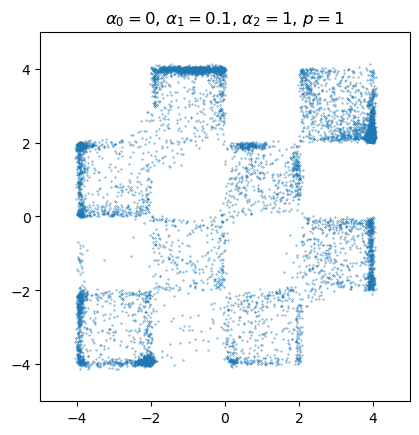

In [43]:
plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
plt.axis('square')
plt.title(r'$\alpha_0 = 0$, $\alpha_1 = 0.1$, $\alpha_2 = 1$, $p = 1$')
plt.axis([-5 ,5 ,-5, 5])

plt.savefig('final_a00a101a21p1.eps',format = 'eps')


(-5.0, 5.0, -5.0, 5.0)

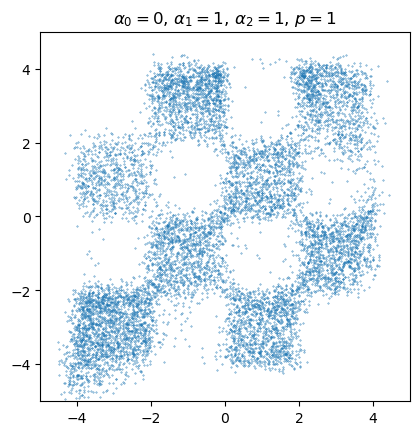

In [13]:
plt.clf()
plt.scatter(samples_lang[:,0],samples_lang[:,1],s = 0.1)
plt.axis('square')
plt.title(r'$\alpha_0 = 0$, $\alpha_1 = 1$, $\alpha_2 = 1$, $p = 2$')
plt.axis([-5 ,5 ,-5, 5])

# plt.savefig('final_a1002a205p2.eps',format = 'eps')


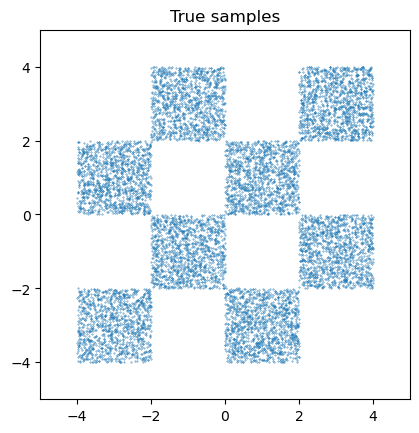

In [80]:
plt.clf()
p_samples = toy_data.inf_train_gen(dataset, batch_size = 10000)
samples_true = torch.tensor(p_samples).to(dtype = torch.float32)
plt.scatter(samples_true[:,0],samples_true[:,1],s = 0.1)
plt.axis('square')
plt.axis([-5 ,5 ,-5, 5])
plt.title('True samples')

plt.savefig('final_truesamples.eps',format = 'eps')


In [46]:
torch.save(scorenet,'hjb_depth3_64_scorenet_p2_a1002_a205') 